# -- Trabalho A3 Inteligência artifical (modelo decision tree implementado) --  

### Importando dependências e bibliotecas: 

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from IPython.display import display, HTML
import graphviz
from io import StringIO
import time 

# Definição do nome do arquivo CSV
FILE_NAME = 'vagas_historico.csv' 
PERCENTUAL_RUIDO_FP = 0.15 # 15% das amostras 'NAO_APTO' serão forçadas a 'APTO' para introduzir Falso Positivo.


# --1. LEITURA DE DADOS E INTRODUÇÃO DO ERRO: --


In [12]:
print("## 1. 📂 Carregamento e Preparação do Dataset Real")

try:
    # Tenta ler o arquivo CSV
    df_historico = pd.read_csv(FILE_NAME)
    print(f"Dataset '{FILE_NAME}' carregado com sucesso. Total de linhas: {len(df_historico)}")
except FileNotFoundError:
    print(f"\n⚠️ ERRO: Arquivo '{FILE_NAME}' não encontrado.")
    print("Gerando um dataset simulado para que o código possa ser executado.")
    # Se o CSV não existir, gera um dataset simulado como fallback
    np.random.seed(42)
    n_samples = 150
    df_historico = pd.DataFrame({
        'Exp_Anos': np.random.randint(0, 12, n_samples),
        'Ingles_Avancado': np.random.randint(0, 2, n_samples), 
        'Conhece_Python': np.random.randint(0, 2, n_samples),
        'Tem_Cloud': np.random.randint(0, 2, n_samples),
    })
    # Cria uma regra de resultado inicial para o dataset simulado
    df_historico['Resultado'] = np.where(
        ((df_historico['Exp_Anos'] >= 5) & (df_historico['Conhece_Python'] == 1)) |
        ((df_historico['Exp_Anos'] >= 8) & (df_historico['Tem_Cloud'] == 1)),
        'APTO', 
        'NAO_APTO'
    )

# --- INJECÇÃO DE RUÍDO (Simulando Falsos Positivos Históricos) ---
# Altera aleatoriamente algumas amostras de 'NAO_APTO' para 'APTO'.
# Isso simula um histórico onde o recrutador contratou pessoas que não estavam
# tecnicamente aptas, ensinando o modelo a ser mais 'otimista' (propenso a FP).

df_nao_apto = df_historico[df_historico['Resultado'] == 'NAO_APTO']
n_ruido = int(len(df_nao_apto) * PERCENTUAL_RUIDO_FP)
indices_ruido = df_nao_apto.sample(n=n_ruido, random_state=42).index

df_historico.loc[indices_ruido, 'Resultado'] = 'APTO' # Injeta o Falso Positivo no dataset de treino

print(f"Ruído injetado: {n_ruido} amostras 'NAO_APTO' foram alteradas para 'APTO' no histórico.")

# Variáveis (Features) e Alvo (Target)
X = df_historico[['Exp_Anos', 'Ingles_Avancado', 'Conhece_Python', 'Tem_Cloud']]
y = df_historico['Resultado']
feature_names = list(X.columns)
class_names = ['APTO', 'NAO_APTO']

# Divisão em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 1. 📂 Carregamento e Preparação do Dataset Real
Dataset 'vagas_historico.csv' carregado com sucesso. Total de linhas: 200
Ruído injetado: 11 amostras 'NAO_APTO' foram alteradas para 'APTO' no histórico.


# --- 2. TREINAMENTO E AVALIAÇÃO DO MODELO ---



In [13]:
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)

print("-" * 70)
print("## 2. 📉 Métricas de Desempenho (Onde o Erro é Visível)")

y_pred = clf.predict(X_test)
acuracia = accuracy_score(y_test, y_pred)
# Ajuste de erro: Se o modelo é 'otimista', esperamos Precisão mais baixa (mais Falsos Positivos)
precision = precision_score(y_test, y_pred, pos_label='APTO', zero_division=0)
recall = recall_score(y_test, y_pred, pos_label='APTO', zero_division=0)
cm = confusion_matrix(y_test, y_pred, labels=['APTO', 'NAO_APTO'])

print(f"Acurácia: {acuracia:.4f}")
print(f"Precisão (Precisão do APTO): {precision:.4f}  <- Deve estar mais baixa devido ao ruído.")
print(f"Recall (Sensibilidade): {recall:.4f}")
print("\nMatriz de Confusão:")
display(pd.DataFrame(cm, index=['Real: APTO', 'Real: NÃO APTO'], columns=['Previsto: APTO', 'Previsto: NÃO APTO']))

# Foco no Falso Positivo (FP):
falso_positivo = cm[1, 0] 
print(f"\nNúmero de Falsos Positivos (FP - Erro que buscamos): {falso_positivo}")

print("-" * 70)

----------------------------------------------------------------------
## 2. 📉 Métricas de Desempenho (Onde o Erro é Visível)
Acurácia: 0.8250
Precisão (Precisão do APTO): 0.8846  <- Deve estar mais baixa devido ao ruído.
Recall (Sensibilidade): 0.8519

Matriz de Confusão:


,Previsto: APTO,Previsto: NÃO APTO
Real: APTO,23,4
Real: NÃO APTO,3,10



Número de Falsos Positivos (FP - Erro que buscamos): 3
----------------------------------------------------------------------


# --- 3. VISUALIZAÇÃO DA ÁRVORE DE DECISÃO ---

## 3. 🌳 Diagrama da Árvore de Decisão


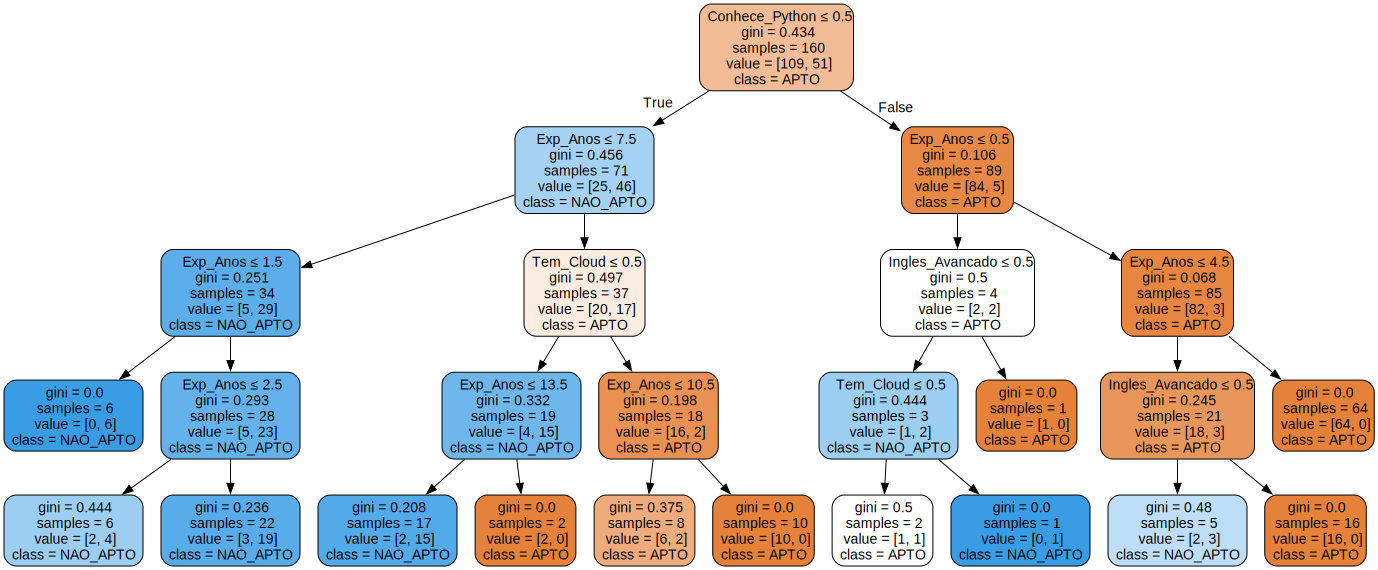

----------------------------------------------------------------------


In [14]:
print("## 3. 🌳 Diagrama da Árvore de Decisão")
# Renderiza o diagrama visual da árvore
dot_data = StringIO()
export_graphviz(clf,
                out_file=dot_data,
                feature_names=feature_names,
                class_names=class_names,
                filled=True,
                rounded=True,
                special_characters=True)

graph = graphviz.Source(dot_data.getvalue())
display(graph)

print("-" * 70)

# --- 4. FILTRAGEM DE NOVAS VAGAS COM VISUALIZAÇÃO DINÂMICA ---



In [17]:
print("## 4. 🔍 Classificação Dinâmica de Novas Vagas")

# Perfil Fixo do Candidato para a Filtragem (Definido aqui)
perfil_fixo = {'Exp_Anos': 1, 'Ingles_Avancado': 0, 'Conhece_Python': 1, 'Tem_Cloud': 0}

print(f"Perfil Fixo do Candidato: {perfil_fixo}")
print("-" * 70)

# Novas Vagas para Classificação (Seu Banco de Dados de Vagas de Produção)
dados_vagas_novas = {
    'ID': [401, 402, 403, 404, 405, 406],
    'Titulo': ['Especialista de Dados', 'Analista Jr', 'Dev Python', 'Arquiteto Cloud', 'Cientista Sênior', 'Analista de Sistemas'],
    'Exp_Anos': [6, 2, 4, 8, 5, 3],           # Exigência de Experiência
    'Ingles_Avancado': [1, 0, 1, 1, 0, 1],   # Exigência de Inglês
    'Conhece_Python': [1, 0, 1, 0, 1, 0],    # Exigência de Python
    'Tem_Cloud': [1, 0, 0, 1, 1, 0]          # Exigência de Cloud
}
df_vagas = pd.DataFrame(dados_vagas_novas)

# Cria a Matriz de Teste (Lógica: Perfil do Candidato atende ou excede a exigência da vaga?)
matriz_teste = pd.DataFrame({
    'Exp_Anos': [perfil_fixo['Exp_Anos'] >= exp for exp in df_vagas['Exp_Anos']],
    'Ingles_Avancado': [perfil_fixo['Ingles_Avancado'] >= req for req in df_vagas['Ingles_Avancado']],
    'Conhece_Python': [perfil_fixo['Conhece_Python'] >= req for req in df_vagas['Conhece_Python']],
    'Tem_Cloud': [perfil_fixo['Tem_Cloud'] >= req for req in df_vagas['Tem_Cloud']],
}).astype(int) 

# DataFrame para rastrear o processo
df_processo = df_vagas.copy()
df_processo['Status'] = 'Pendente'
df_processo['Predicao'] = ''

# Loop para análise e visualização dinâmica
for index, row in matriz_teste.iterrows():
    # 1. Predição do modelo para a vaga atual
    vaga_atual_data = np.array(row).reshape(1, -1)
    predicao = clf.predict(vaga_atual_data)[0]
    
    # 2. Atualiza o DataFrame de Processo
    df_processo.loc[index, 'Predicao'] = predicao
    df_processo.loc[index, 'Status'] = 'Analisada'
    
    # 3. Formatação Dinâmica para destaque
    def destacar_vaga(s):
        is_current = (s.name == index)
        is_apto = (s['Predicao'] == 'APTO')
        
        if is_current:
            return ['background-color: yellow; color: black' if True else '' for _ in s]
        elif s['Status'] == 'Analisada' and is_apto:
            return ['background-color: #d4edda; color: #155724' if True else '' for _ in s]
        elif s['Status'] == 'Analisada':
            return ['background-color: #f8d7da; color: #721c24' if True else '' for _ in s]
        return ['' for _ in s]

    # Exibe a tabela atualizada
    display(HTML(f"<h3>Analisando Vaga {df_processo.loc[index, 'ID']}: {df_processo.loc[index, 'Titulo']}</h3>"))
    display(df_processo[['Titulo', 'Exp_Anos', 'Ingles_Avancado', 'Conhece_Python', 'Tem_Cloud', 'Status', 'Predicao']].style.apply(destacar_vaga, axis=1))
    display(HTML("<hr>"))
    time.sleep(1)

## 4. 🔍 Classificação Dinâmica de Novas Vagas
Perfil Fixo do Candidato: {'Exp_Anos': 1, 'Ingles_Avancado': 0, 'Conhece_Python': 1, 'Tem_Cloud': 0}
----------------------------------------------------------------------


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


,Titulo,Exp_Anos,Ingles_Avancado,Conhece_Python,Tem_Cloud,Status,Predicao
0,Especialista de Dados,6,1,1,1,Analisada,APTO
1,Analista Jr,2,0,0,0,Pendente,
2,Dev Python,4,1,1,0,Pendente,
3,Arquiteto Cloud,8,1,0,1,Pendente,
4,Cientista Sênior,5,0,1,1,Pendente,
5,Analista de Sistemas,3,1,0,0,Pendente,


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


,Titulo,Exp_Anos,Ingles_Avancado,Conhece_Python,Tem_Cloud,Status,Predicao
0,Especialista de Dados,6,1,1,1,Analisada,APTO
1,Analista Jr,2,0,0,0,Analisada,APTO
2,Dev Python,4,1,1,0,Pendente,
3,Arquiteto Cloud,8,1,0,1,Pendente,
4,Cientista Sênior,5,0,1,1,Pendente,
5,Analista de Sistemas,3,1,0,0,Pendente,


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


,Titulo,Exp_Anos,Ingles_Avancado,Conhece_Python,Tem_Cloud,Status,Predicao
0,Especialista de Dados,6,1,1,1,Analisada,APTO
1,Analista Jr,2,0,0,0,Analisada,APTO
2,Dev Python,4,1,1,0,Analisada,NAO_APTO
3,Arquiteto Cloud,8,1,0,1,Pendente,
4,Cientista Sênior,5,0,1,1,Pendente,
5,Analista de Sistemas,3,1,0,0,Pendente,


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


,Titulo,Exp_Anos,Ingles_Avancado,Conhece_Python,Tem_Cloud,Status,Predicao
0,Especialista de Dados,6,1,1,1,Analisada,APTO
1,Analista Jr,2,0,0,0,Analisada,APTO
2,Dev Python,4,1,1,0,Analisada,NAO_APTO
3,Arquiteto Cloud,8,1,0,1,Analisada,APTO
4,Cientista Sênior,5,0,1,1,Pendente,
5,Analista de Sistemas,3,1,0,0,Pendente,


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


,Titulo,Exp_Anos,Ingles_Avancado,Conhece_Python,Tem_Cloud,Status,Predicao
0,Especialista de Dados,6,1,1,1,Analisada,APTO
1,Analista Jr,2,0,0,0,Analisada,APTO
2,Dev Python,4,1,1,0,Analisada,NAO_APTO
3,Arquiteto Cloud,8,1,0,1,Analisada,APTO
4,Cientista Sênior,5,0,1,1,Analisada,APTO
5,Analista de Sistemas,3,1,0,0,Pendente,


/usr/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


,Titulo,Exp_Anos,Ingles_Avancado,Conhece_Python,Tem_Cloud,Status,Predicao
0,Especialista de Dados,6,1,1,1,Analisada,APTO
1,Analista Jr,2,0,0,0,Analisada,APTO
2,Dev Python,4,1,1,0,Analisada,NAO_APTO
3,Arquiteto Cloud,8,1,0,1,Analisada,APTO
4,Cientista Sênior,5,0,1,1,Analisada,APTO
5,Analista de Sistemas,3,1,0,0,Analisada,NAO_APTO


# 5. RESULTADO FINAL (FILTRO)


In [20]:
print("## 5. ✅ Filtro Final de Vagas Aptas")
vagas_aptas = df_processo[df_processo['Predicao'] == 'APTO']
display(vagas_aptas[['Titulo', 'Predicao']].style.hide(axis='index'))

## 5. ✅ Filtro Final de Vagas Aptas


Titulo,Predicao
Especialista de Dados,APTO
Analista Jr,APTO
Arquiteto Cloud,APTO
Cientista Sênior,APTO
